<a href="https://colab.research.google.com/github/Diyon335/PRA3024/blob/master/Week5_Jacco/GYM_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#For running in Google colab some features will differ
COLAB = True

if(COLAB) :
  # Install some helpers to visualize gym graphics in the colab environment
  !pip install gym pyvirtualdisplay > /dev/null 2>&1
  !apt-get install -y xvfb python-opengl ffmpeg x11-utils > /dev/null 2>&1

In [0]:
import gym
import numpy as np
from matplotlib import pyplot as plt
import random

from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [0]:
#Only necessary for visualisation in colab environment
if(COLAB) :
  from IPython.display import HTML
  from IPython import display as ipythondisplay
  from pyvirtualdisplay import Display
  from gym.wrappers import Monitor
  import glob, io, os, base64
  from moviepy.editor import VideoFileClip, concatenate_videoclips

  display = Display(visible=0, size=(1400, 900))
  display.start()
  os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

  def combine_videos() :
    mp4list = sorted( glob.glob('video/*.mp4') )
    if len(mp4list) > 0 :
      videolist = []
      for mp4 in mp4list :
        videolist.append( VideoFileClip(mp4))
      final_clip = concatenate_videoclips(videolist)
      final_clip.to_videofile("combined.mp4", fps=24, remove_temp=False)
      return 1
    else :
      return 0

  def show_video() :
      if(combine_videos()) :
        video = io.open("combined.mp4", 'r+b').read()

        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                  loop controls style="height: 400px;">
                  <source src="data:video/mp4;base64,{0}" type="video/mp4" />
               </video>'''.format(encoded.decode('ascii'))))
      else :
        print("Error: no videos found")     


  def wrap_env(env):
    env = Monitor(env, './video', video_callable=lambda episode_id: True, force=True)
    return env

In [0]:
#Get our environment
ENV_NAME = "CartPole-v1"

MAXRUNS = 50
NSTEPSOLVED = 1000

#Future discount factor
GAMMA = 0.9
LEARNING_RATE = 0.001 # rate at which to update weights after each training step

MEMORY_SIZE = 1000000 # size of container to hold actions and outcomes
BATCH_SIZE = 32 # number of actions in memory to 'replay' after each death

# probability to do 'random' actions, to sample from event space
EXPLORATION_MAX = 1.0  
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.995   


In [0]:
class DQNSolver:

    def __init__(self, observation_space, action_space):
        self.exploration_rate = EXPLORATION_MAX

        self.action_space = action_space
        self.memory = deque(maxlen=MEMORY_SIZE)

        # This will be a simple feed-forward NN, with 
        #  - input = 'observation' (aka state)
        #  - output = predicted 'quality' of each possible action
        self.model = Sequential()

        ####
        self.model.add(Dense(32, input_shape=(observation_space,), activation="relu"))
        self.model.add(Dense(32, activation="relu"))
        self.model.add(Dense(self.action_space, activation="linear"))
        ####
        
        self.model.compile(loss="mse", optimizer=Adam(lr=LEARNING_RATE))
        self.model.summary()
        
    def remember(self, state, action, reward, next_state, done):
        
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.action_space)
        
        q_values = self.model.predict(state) 
        return np.argmax(q_values[0])

    def experience_replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        
        batch = random.sample(self.memory, BATCH_SIZE) 
        
        for state, action, reward, state_next, terminal in batch:
          
            q_update = reward
            if not terminal:
                q_update = (reward + GAMMA * np.amax(self.model.predict(state_next)[0]))
                #q_update -= 1.0 * abs(state_next[0][2]) - abs(state[0][2]) # penalize angle increases for cartpole
                
            q_values = self.model.predict(state)
            q_values[0][action] = q_update 
            
            self.model.fit(state, q_values, verbose=0) 
            
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

In [0]:
def cartpole() :
    if(COLAB) : env = wrap_env(gym.make(ENV_NAME)) # only for visualisation in colab
    else : env = gym.make(ENV_NAME)

    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    dqn_solver = DQNSolver(observation_space, action_space)
       
    run=0
    runsteplog = []
    #while True:
    for i in range(MAXRUNS):
        run += 1
        state = env.reset()
        state = np.reshape(state, [1, observation_space])
        step = 0
        
        while True :    
            step += 1
            screen = env.render() # graphical output

            action = dqn_solver.act(state) # (this takes a random action)
            
            # make the action
            state_next, reward, terminal, info = env.step(action) 

            # if action made terminal: reduce reward!
            reward = reward if not terminal else -reward  

            state_next = np.reshape(state_next, [1, observation_space])

            # fill agent memory with this action's results
            dqn_solver.remember(state, action, reward, state_next, terminal) 

            # prepare for the next action in the environment
            state = state_next 
            
            if terminal :
                #state = env.reset()
                #state = np.reshape(state, [1, observation_space])
                print("Run: {0}, exploration: {1:.15f}, score: {2}".format(run,dqn_solver.exploration_rate,step))
                runsteplog += [step]

                break
            
            dqn_solver.experience_replay() # learn from batch of memories every time a new one is made

    env.close()
    


    # Show training process
    
    # plot #steps achieved
    plt.plot(runsteplog)
    plt.ylabel("# actions before terminal")
    plt.xlabel("run iteration")

    success_measure = np.mean(runsteplog[-15:])
    print("Mean of last 15 runs: {0}".format(success_measure))
    return success_measure

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_11 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
Run: 1, exploration: 1.000000000000000, score: 15
Run: 2, exploration: 0.922931123974236, score: 33
Run: 3, exploration: 0.830718701482133, score: 22
Run: 4, exploration: 0.798065677681905, score: 9
Run: 5, exploration: 0.679793828332658, score: 33
Run: 6, exploration: 0.633724281764409, score: 15
Run: 7, exploration: 0.539807521680817, score: 33
Run: 8, exploration: 0.5211953074

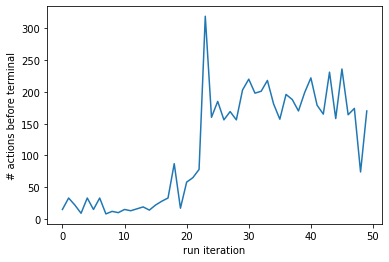

In [15]:
MAXRUNS = 50

if __name__ == "__main__":
    cartpole()

In [16]:
if(COLAB) :
  show_video() 

[MoviePy] >>>> Building video combined.mp4
[MoviePy] Writing video combined.mp4


100%|██████████| 2762/2762 [00:16<00:00, 172.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: combined.mp4 

